In [1]:
# Import the required packages
import pandas as pd
import numpy as np
from scipy import stats

In [2]:
# Import the file
df = pd.read_csv('diabetic_data.csv')

In [3]:
# Show the shape
df.shape

(101766, 50)

In [4]:
# Replace all '?' with NaN
df.replace('?', np.nan, inplace=True)

In [5]:
# Removes columns with over 50% NaN values
x = df.isnull().sum()/len(df)
to_remove = x[x>0.5].index

print("Removed: " + ", ".join(to_remove))
df.drop(columns=to_remove, inplace=True)

Removed: weight


In [6]:
# Removes columns with 95% same value
to_remove = []

for i in df.columns:
    
    top_freq = df[i].value_counts(normalize=True)
    top_freq = top_freq.max()
    
    if top_freq > 0.95:
        to_remove.append(i)

print("Removed :", to_remove)

df.drop(columns=to_remove, inplace=True)

Removed : ['repaglinide', 'nateglinide', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']


In [7]:
# Sets all ages to the average of their range
def normalise_age(age):
    num = age[1:-1]
    num1, num2 = num.split('-')
    average = (int(num1) + int(num2)) / 2
    return average

try:
    df['age'] = df['age'].apply(normalise_age)
    print("Age normalised")
except Exception:
    print("Failed")

Age normalised


In [8]:
# Sets NaN values in diag_1, diag_2 and diag_3 to 0
df[['diag_1', 'diag_2', 'diag_3']] = df[['diag_1', 'diag_2', 'diag_3']].fillna(0)

In [9]:
# Drops all rows with missing values
df.dropna(inplace=True)

In [42]:
# Identify all numerical features, create lists for numerical and categorical
# https://pandas.pydata.org/docs/reference/api/pandas.api.types.is_numeric_dtype.html

cat_list = []
num_list = []
for i in df.columns:
    if pd.api.types.is_numeric_dtype(df[i]):
        num_list.append(df[i].name)
    else:
        cat_list.append(df[i].name)
        
print("Categorical: \n\n"+", ".join(cat_list))
print("\nNumerical: \n\n"+", ".join(num_list))

Categorical: 

race, gender, payer_code, medical_specialty, diag_1, diag_2, diag_3, max_glu_serum, A1Cresult, metformin, glimepiride, glipizide, glyburide, pioglitazone, rosiglitazone, insulin, change, diabetesMed

Numerical: 

encounter_id, patient_nbr, age, admission_type_id, discharge_disposition_id, admission_source_id, time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, number_diagnoses, readmitted


In [11]:
# Remove rows which contains outliers (3STD)

for col in num_list:
    mean = df[col].mean()
    std = df[col].std()

    upper = mean + 3 * std
    lower = mean - 3 * std
    
    df = df[(df[col] >= lower) & (df[col] <= upper)]

In [44]:
# Removes duplicates in the column patient_nbr
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html
df.drop_duplicates(subset="patient_nbr", inplace=True)

In [45]:
df.shape

(17507, 33)

In [46]:
# Sets readmitted to 1 for true and 0 for false
df['readmitted'].replace('NO', 0, inplace=True)
df['readmitted'].replace('>30', 1, inplace=True)
df['readmitted'].replace('<30', 1, inplace=True)
df['readmitted'].value_counts()

0    10974
1     6533
Name: readmitted, dtype: int64

In [47]:
import matplotlib.pyplot as plt

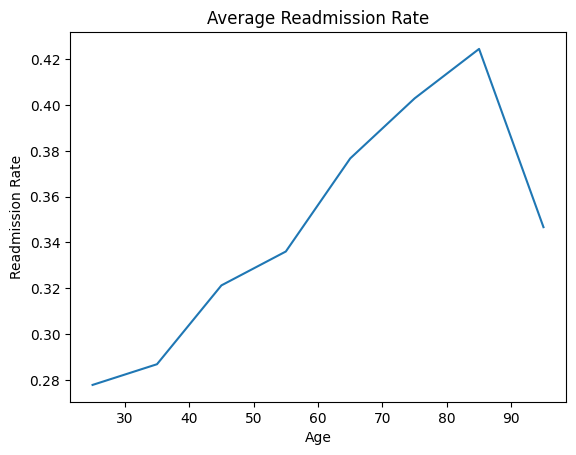

In [48]:
# Visualise the admission rate by age group

df_agegroup = df.groupby('age')['readmitted']

plt.plot(df_agegroup.mean())

plt.title('Average Readmission Rate')
plt.xlabel('Age')
plt.ylabel('Readmission Rate')
plt.show()

In [51]:
print("Population per Race") 
race_population = df['race'].value_counts()
print(race_population,"\n")

print("Readmission Rate per Race")
race_readmission_rate = df.groupby('race')['readmitted'].mean()
print(race_readmission_rate,"\n")

print("Readmission without African Americans")
without_aa = df[df['race']!='AfricanAmerican']
x = without_aa['readmitted']
print(x.mean()*100)
print("Overall readmission rate")
overall_readmission_rate = df['readmitted'].mean()
print(overall_readmission_rate*100)

print("\n% Caucasian ")
print(df['race'].value_counts().get('Caucasian', 0)/df['race'].value_counts().sum()*100,"%")
print("% Hispanic ")
print(df['race'].value_counts().get('Hispanic', 0)/df['race'].value_counts().sum()*100,"%\n")

Population per Race
Caucasian          13211
AfricanAmerican     3515
Hispanic             331
Other                305
Asian                145
Name: race, dtype: int64 

Readmission Rate per Race
race
AfricanAmerican    0.330299
Asian              0.337931
Caucasian          0.386799
Hispanic           0.311178
Other              0.360656
Name: readmitted, dtype: float64 

Readmission without African Americans
38.39336763865065
Overall readmission rate
37.31650197064032

% Caucasian 
75.46124407379905 %
% Hispanic 
1.8906723025075685 %



In [18]:
from scipy.stats import chi2_contingency

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html

x = df[(df['race'] == 'AfricanAmerican') & (df['readmitted'] == 1)]
x = x['readmitted'].value_counts().sum()
y = df[(df['race'] == 'AfricanAmerican') & (df['readmitted'] == 0)]
y = y['readmitted'].value_counts().sum()
       
table = np.array([[x,y], [df[df['readmitted'] == 1].shape[0]-x, df[df['readmitted'] == 0].shape[0]-y]])
print(table)
res = chi2_contingency(table)
print(res.pvalue)

[[ 1822  2972]
 [ 7980 10542]]
2.4192922365570316e-10


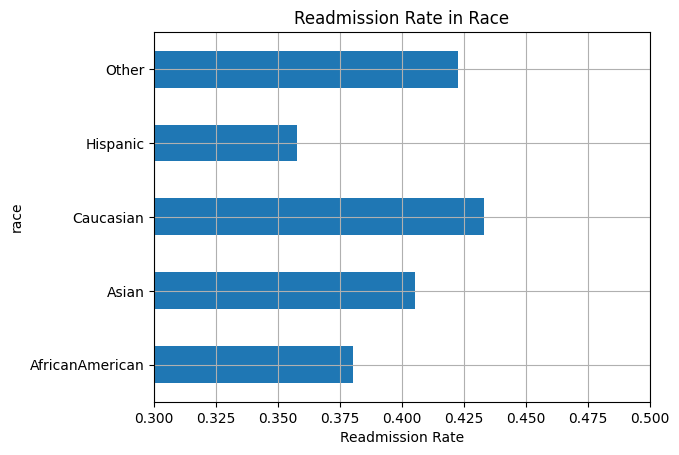

In [19]:
race_readmission_rate.plot(kind='barh')
    
plt.title('Readmission Rate in Race')
plt.xlabel('Readmission Rate')
plt.grid()
plt.xlim(0.3,0.5)
plt.show()


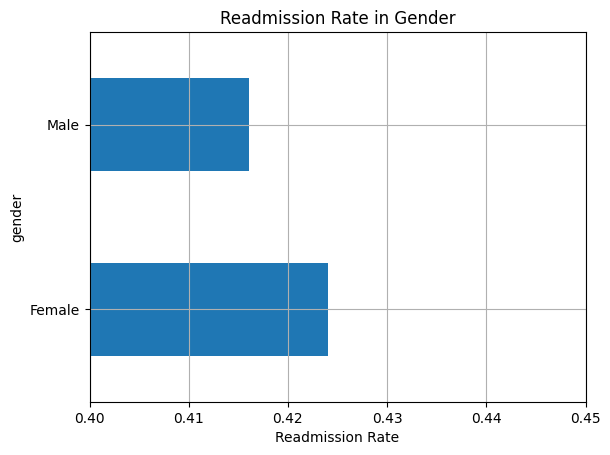

In [20]:
df_gendergroup = df.groupby('gender')['readmitted'].mean()

df_gendergroup.plot(kind='barh')

plt.title('Readmission Rate in Gender')
plt.xlabel('Readmission Rate')
plt.grid()
plt.xlim(0.4,0.45)
plt.show()

In [21]:
df_id = pd.read_csv('icd_codes.csv')
df_newid = df_id

def find_id(i):
    try:
        i=float(i)
        if((i>=390 and i<=459)or(i==785)):
            return "Circulatory System Disease"
        elif(i>=250.001 and i<=250.999):
            return "Diabetes"
        elif((i>=460 and i<=519)or(i==786)):
            return "Respiratory System Disease"
        elif((i>=520 and i<=579)or(i==787)):
            return "Digestive System Disease"
        elif((i>=800 and i<=999)):
            return "Injury and poisoning"
        elif((i>=710 and i<=739)):
            return "Musculoskeletal System Disease"
        elif((i>=580 and i<=629)or(i==788)):
            return "Genitourinary System Disease"
        elif((i>=140 and i<=239)):
            return "Neoplasms"
        else:
            return "Other"
    except:
        i = str(i)
        if(i[0]=="E"):
            return "Physical Injury"
        elif(i[0]=="V"):
            return "Health Complication"
        else:
            return "Other"
    return "Other"
            
    

In [22]:
df['diag_1'] = df['diag_1'].apply(find_id)
df['diag_2'] = df['diag_2'].apply(find_id)
df['diag_3'] = df['diag_3'].apply(find_id)

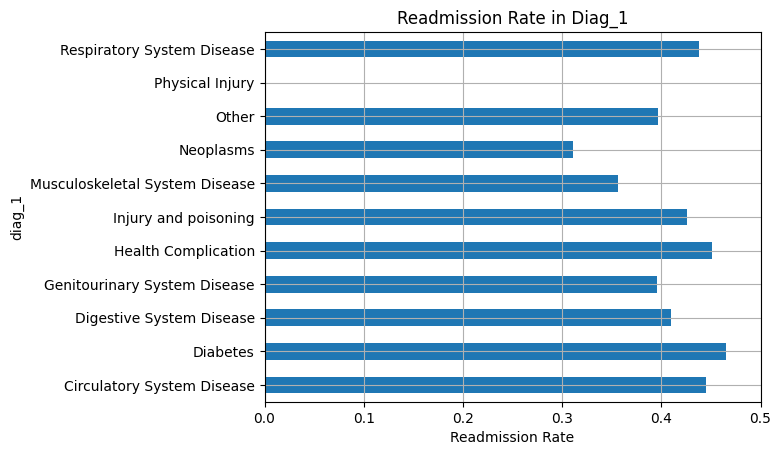

In [23]:
df_diaggroup = df.groupby('diag_1')['readmitted'].mean()

df_diaggroup.plot(kind='barh')
    
plt.title('Readmission Rate in Diag_1')
plt.xlabel('Readmission Rate')
plt.grid()
plt.xlim(0.0,0.5)
plt.show()

# NOTE -
# There are no 'Physical Injury' entries in Diag_1

In [24]:
df_model = df[['num_medications', 'number_outpatient', 'number_emergency', 'time_in_hospital', 'number_inpatient','encounter_id', 'age', 'num_lab_procedures', 'number_diagnoses','num_procedures', 'readmitted']]

In [25]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection, linear_model
from sklearn.metrics import confusion_matrix

In [26]:
# Normalise
df_model=((df_model-df_model.min())/(df_model.max()-df_model.min()))

In [27]:
# Remove ID as has no corrolation to readmission 
df_model = df_model.drop(['encounter_id', 'readmitted'], axis=1)

In [28]:
# Calculate training / test scores
clf = linear_model.LogisticRegression()

X = df_model
Y = df['readmitted']
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

clf.fit(X_train, Y_train)

print("Training data score:\t",clf.score(X_train, Y_train))
print("Test data score:\t",clf.score(X_test, Y_test))


Training data score:	 0.63076345700193
Test data score:	 0.6181389365351629


In [29]:
# Show the confusion matrix

prob_df = pd.DataFrame(clf.predict_proba(X_test)[:, 1])
prob_df['predict'] = np.where(prob_df[0]>=0.5, 1, 0)
prob_df['actual'] = Y_test.reset_index(drop=True)

cmatrix = pd.crosstab(prob_df['actual'], prob_df['predict'])
print("Threshold of 0.5\n\n", cmatrix)

Threshold of 0.5

 predict     0    1
actual            
0        2253  393
1        1388  630


TN = 2253
FP = 393
FN = 1388
TP = 630

In [30]:
CV_score = model_selection.cross_val_score(clf, X_test, Y_test, scoring='accuracy', cv=5)
print("Cross validation score:",CV_score.mean())

# Shows accuracy when using 5 folds in the data
# Cross validation shows that the initial values are accurate

Cross validation score: 0.6200672527128788


In [31]:
df.columns
df_model2 = df[['encounter_id','patient_nbr','race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin', 'change', 'diabetesMed']]

cat_list.remove('readmitted')

In [32]:
# Normalise
df_model2_norm=((df_model2[num_list]-df_model2[num_list].min())/(df_model2[num_list].max()-df_model2[num_list].min()))

df_model2_dummies = pd.get_dummies(df_model2[cat_list])

df_model2_processed = pd.concat([df_model2_norm, df_model2_dummies], axis=1)

In [33]:
df_model2_processed

,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,rosiglitazone_Steady,rosiglitazone_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
20737,0.000000,0.121866,0.571429,0.5,0.000000,0.000000,0.166667,0.585859,0.500000,0.250,...,0,0,0,0,1,0,0,1,0,1
20824,0.000586,0.122047,1.000000,0.0,0.000000,0.500000,0.250000,0.555556,0.166667,0.200,...,0,0,0,1,0,0,0,1,0,1
21083,0.002423,0.122853,0.714286,0.0,0.071429,0.500000,0.750000,0.676768,0.166667,0.425,...,0,0,0,0,1,0,1,0,0,1
23879,0.023341,0.043293,0.714286,0.0,0.142857,0.416667,0.916667,0.767677,0.833333,0.450,...,0,0,0,0,1,0,0,1,0,1
23922,0.023623,0.092492,0.714286,0.0,0.142857,0.416667,0.916667,0.595960,0.833333,0.225,...,0,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101278,0.999939,0.314893,0.571429,0.0,0.000000,0.500000,0.500000,0.535354,0.666667,0.325,...,0,0,0,1,0,0,0,1,0,1
101281,0.999969,0.583644,0.571429,1.0,0.000000,0.000000,0.166667,0.202020,0.666667,0.250,...,0,0,0,1,0,0,0,1,1,0
101282,0.999970,0.265561,0.857143,0.0,0.357143,0.500000,0.166667,0.343434,0.000000,0.375,...,0,0,0,0,1,0,0,1,0,1
101284,1.000000,0.849389,0.857143,0.5,0.000000,0.250000,0.166667,0.000000,0.000000,0.350,...,0,0,0,0,0,1,1,0,0,1


In [34]:
# Calculate training / test scores
clf = linear_model.LogisticRegression(max_iter=1000)

X = df_model2_processed
Y = df['readmitted']
    
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

clf.fit(X_train, Y_train)

print("Training data score:\t",clf.score(X_train, Y_train))
print("Test data score:\t",clf.score(X_test, Y_test))

Training data score:	 0.6640038601758524
Test data score:	 0.6672384219554031


In [35]:
CV_score = model_selection.cross_val_score(clf, X_test, Y_test, scoring='accuracy', cv=5)
print("Cross validation score:",CV_score.mean())

# Shows accuracy when using 5 folds in the data
# Cross validation shows that the initial values are accurate

Cross validation score: 0.6584512095828216


In [36]:
# Show the confusion matrix

prob_df = pd.DataFrame(clf.predict_proba(X_test)[:, 1])
prob_df['predict'] = np.where(prob_df[0]>=0.45, 1, 0)
prob_df['actual'] = Y_test.reset_index(drop=True)

cmatrix = pd.crosstab(prob_df['actual'], prob_df['predict'])
print("Threshold of 0.45\n\n", cmatrix)

Threshold of 0.45

 predict     0     1
actual             
0        1922   756
1         807  1179


In [37]:
# With help from Lecture 8 Notes

df_model2_processed = df_model2_processed[['age', 'race_AfricanAmerican',
 'race_Asian',
 'race_Caucasian',
 'race_Hispanic',
 'race_Other',
 'diag_1_Circulatory System Disease',
 'diag_1_Diabetes',
 'diag_1_Digestive System Disease',
 'diag_1_Genitourinary System Disease',
 'diag_1_Health Complication',
 'diag_1_Injury and poisoning',
 'diag_1_Musculoskeletal System Disease',
 'diag_1_Neoplasms',
 'diag_1_Other',
 'diag_1_Physical Injury',
 'diag_1_Respiratory System Disease',
 'gender_Female',
 'gender_Male']]


from sklearn.cluster import KMeans
from sklearn import datasets

model = KMeans(n_clusters=3, n_init=10)
model.fit(df_model2_processed)

md = model.labels_

df_model2_processed['clust']=md

C:\Users\Jack\AppData\Local\Temp\ipykernel_14088\1903376996.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model2_processed['clust']=md


In [38]:
print(df_model2_processed.shape)

(23316, 20)


In [39]:
df_model2_processed['clust'].value_counts()
# Number of entries in each cluster

2    9639
1    8883
0    4794
Name: clust, dtype: int64

In [40]:
# Extracting proportion values from the cluster

average_ages = df_model2_processed.groupby('clust')['age'].mean()
print("Average Normalized age: ",average_ages*100)

average_male = df_model2_processed.groupby('clust')['gender_Male'].mean()
print("Male % : ",(average_male*100))

average_female = df_model2_processed.groupby('clust')['gender_Female'].mean()
print("Female % : ",(average_female*100))

average_cauc = df_model2_processed.groupby('clust')['race_Caucasian'].mean()
print("Caucasian % : ",(average_cauc*100))

average_aa = df_model2_processed.groupby('clust')['race_AfricanAmerican'].mean()
print("AfricanAmerican % : ",(average_aa*100))

average_d1_resp = df_model2_processed.groupby('clust')['diag_1_Respiratory System Disease'].mean()
print("Respiratory % : ",(average_d1_resp*100))

average_d1_resp = df_model2_processed.groupby('clust')['diag_1_Physical Injury'].mean()
print("Physical Injury % : ",(average_d1_resp*100))

average_d1_resp = df_model2_processed.groupby('clust')['diag_1_Injury and poisoning'].mean()
print("Injury and poisoning % : ",(average_d1_resp*100))

average_d1_resp = df_model2_processed.groupby('clust')['diag_1_Neoplasms'].mean()
print("Neoplasms % : ",(average_d1_resp*100))


Average Normalized age:  clust
0    52.929257
1    59.202972
2    63.656574
Name: age, dtype: float64
Male % :  clust
0     37.025448
1    100.000000
2      0.000000
Name: gender_Male, dtype: float64
Female % :  clust
0     62.974552
1      0.000000
2    100.000000
Name: gender_Female, dtype: float64
Caucasian % :  clust
0     0.000000
1    93.920973
2    94.511879
Name: race_Caucasian, dtype: float64
AfricanAmerican % :  clust
0    100.0
1      0.0
2      0.0
Name: race_AfricanAmerican, dtype: float64
Respiratory % :  clust
0    13.475177
1    13.137454
2    15.499533
Name: diag_1_Respiratory System Disease, dtype: float64
Physical Injury % :  clust
0    0.000000
1    0.000000
2    0.010375
Name: diag_1_Physical Injury, dtype: float64
Injury and poisoning % :  clust
0    6.216103
1    6.428009
2    7.749767
Name: diag_1_Injury and poisoning, dtype: float64
Injury and poisoning % :  clust
0    3.108052
1    4.221547
2    3.714078
Name: diag_1_Neoplasms, dtype: float64
